<h1><center>Lab 7 - A7</center></h1>
<h1><center>Particle Swarm Optimization</center></h1>

In [1]:
import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Sphere Function
The Sphere Function, also called De Jong’s function 1, has the following formula:
$$ f_1(x) = \sum_{i=1}^n x_i^2  \quad -5.12 \leq x_i \leq 5.12 $$
Global optimum: $f(x)=0, \,\, x(i)=0, \,\, i=1:n$.  
It is continuos, convex and unimodal. Number of local minima: no local minimum except the global one.

In [33]:
# Evaluation function for Sphere

def sphere_fitness(vector):
  '''
    Returns the sphere function value for the vector x .
    Input:
      - vector: list[float] -> size = n
    Output:
      - value: float
  '''
  return np.sum(vector ** 2)

# Weighted Sphere Function
The Weighted Sphere Function (Axis parallel hyper-ellipsoid) is described by the following formula:
$$ f_1(x) = \sum_{i=1}^n i \cdot x_i^2  \quad -5.12 \leq x_i \leq 5.12 $$
Global optimum: $f(x)=0, \,\, x(i)=0, \,\, i=1:n$.  
It is continuos, convex and unimodal. Number of local minima: no local minimum except the global one.

In [51]:
# Evaluation function for Weighted Sphere

def weighted_sphere_fitness(vector):
  '''
    Returns the weighted sphere function value for the vector x .
    Input:
      - vector: list[float] -> size = n
    Output:
      - value: float
  '''
  coeff = np.arange(1, len(vector) + 1)
  return np.sum(coeff * vector ** 2)

# Particle Swarm Optimization Algorithm
  
Uses a population of vectors (called swarm), each vector has a position, a velocity and a record of its best position. Additionally, it keeps track of the best position found within the swarm.  
  
Pseudocode algorithm:
- Initialize positions, velocities, best positions and swarm best position.
- For a number of maximum iterations:
  - the new velocity for each particle is calculated,
  - the position of each particle is updated,
  - best position for each particle and for the swarm is updated.
- The best position (solution) is returned.
  
Function for calculating the updated velocity:  
$$ v_{i,d} = w \cdot v_{i,d} + \phi_p \cdot r_p \cdot (p_{i,d} - x_{i,d}) + \phi_g \cdot r_g \cdot (g_d - x_{i,d}) $$  
- Here, $d=1,...\,n$ represents the dimension, and $i=1,...\,m$ represents the index of the particle within the swarm.  
- Additionally, $r_p$ and $r_g$ are random real numbers within $0$ and $1$ and $\phi_p$ and $\phi_g$ are the cognitive and social coefficients (also real numbers, tipically between $1.5$ and $2$).
  
The inertia weight ($w$) can either be static, or dinamic. For dynamic $w$ we can use the following formula:
$$ w(t) = (w_{max} - w_{min}) * Ps(t) + w_{min} $$
- Here, $w_{min}$ and $w_{max}$ are typically set to 0.9 and 0.4.
- $Ps(t)$ represents the ratio of particles that succeeded to enhance their fitness in the previous iteration over the swarm size.
- This means that while many better solutions are being discovered, exploration is encouraged, and while few better solutions are discovered, the main focus is on explotation (for fine-tuning solutions).

## Particle Swarm Optimization algorithm helper functions

In [35]:
# Helper functions for the PSO algorithm

def generate_vector(n, min_value, max_value):
  '''
    Generates a random vector of real numbers belonging to the interval [min_value, max_value]
    Input:
      - n: int
      - min_value, max_value: float
    Output:
      - vector: list[float]
  '''
  vector = np.random.uniform(low=min_value, high=max_value, size=(n,))
  return vector

def generate_velocity(n, min_value, max_value):
  '''
    Generates a random velocity vector of real numbers belonging to the interval 
      [-(max_value - min_value), max_value - min_value]
    Input:
      - n: int
      - min_value, max_value: float
    Output:
      - vector: list[float]
  '''
  diff = max_value - min_value
  vector = np.random.uniform(low=-diff, high=diff, size=(n,))
  return vector

def update_velocity(n, position, best_position, swarm_best_position, velocity, w, phi_p, phi_g, min_value, max_value):
  '''
    Generates a velocity vector according to the velocity update formula
    Input:
      - n: int
      - position, velocity: list[float]
      - best_position, swarm_best_position: list[float]
      - w, phi_p, phi_g: float
    Output:
      - new_velocity: list[float]
  '''
  # generate r_p, r_g: vectors of random numbers
  r_p = np.random.rand(n)
  r_g = np.random.rand(n)
  # apply velocity update formula
  cognitive = phi_p * r_p * (best_position - position)
  social = phi_g * r_g * (swarm_best_position - position)
  new_velocity = w * velocity + cognitive + social
  # cap velocity
  diff = max_value - min_value
  new_velocity = np.clip(new_velocity, -diff, diff)
  # return new velocity
  return new_velocity

def update_w(w_min, w_max, ps):
  '''
    Updates the inertia weight according to the adaptive strategy
      proposed by A. Nickabadi, M. M. Ebadzadeh, and R. Safabakhsh (2011)
    Input:
      - w_min, w_max: float
      - ps: float (0,1)
    Output:
      - float (w)
  '''
  return ps * (w_max - w_min) + w_min

## Particle Swarm Optimization Algorithm for a Function Minimization Problem

In [39]:
# Particle Swarm Optimization algorithm for a Function minimization problem

def pso_algorithm(n, min_value, max_value, fitness_func, swarm_size=50, max_iterations=100, w=0.6, phi_p=1.75, phi_g=1.75, w_strategy='static', w_min=0.4, w_max=0.9):
  '''
    Implements a particle swarm algorithm for a Function minimization problem
    Input:
      - n: int (vector dimensions)
      - min_value, max_value: float (function bounds)
      - fitness_func: function(list[float]) -> float
      - swarm_size: int
      - max_iterations: int
      - w: float (inertia weight)
      - phi_p: float (Cognitive coefficient — attraction to the particle's own best position)
      - phi_g: float (Social coefficient — attraction to the swar's global best.)
      - w_strategy: {'static', 'adaptive'}
      - w_min, w_max: float (min / max inertia weight for adaptive strategy)
    Output:
      - swarm_best_position: list[float]
      - best_fitness: float
  '''
  # initialize positions and velocities list
  positions = []
  velocities = []
  # initialize best positions list and global best position
  best_positions = []
  swarm_best_position = np.ones(n) * np.inf

  # initialize particles
  for i in range(swarm_size):
    # position and velocity
    position = generate_vector(n, min_value, max_value)
    positions.append(position)
    velocity = generate_velocity(n, min_value, max_value)
    velocities.append(velocity)
    # best positions
    best_positions.append(position)
    if fitness_func(position) < fitness_func(swarm_best_position):
      swarm_best_position = position
  
  # initialize iteration
  iteration = 0

  # initialize performance score for adaptive strategy
  # (particles that succeeded to enhance their fitness in the previous iteration) / swarm_size
  if w_strategy == 'adaptive':
    ps = 1
  
  while iteration < max_iterations:
    # update particles
    for i in range(swarm_size):
      position, velocity, best_position = positions[i], velocities[i], best_positions[i]

      # update w for adaptive strategy
      if w_strategy == 'adaptive':
        w = update_w(w_min, w_max, ps)
      
      # update velocity
      new_velocity = update_velocity(n, position, best_position, swarm_best_position, velocity, w, phi_p, phi_g, min_value, max_value)
      velocities[i] = new_velocity

      # update position
      new_position = np.clip(position + new_velocity, min_value, max_value)
      positions[i] = new_position

      # initialize number of improvements for adaptive strategy
      if w_strategy == 'adaptive':
        improvements = 0
      
      # update particle best position
      # if w_strategy is adaptive, increment number of improvements
      if fitness_func(new_position) < fitness_func(best_position):
        best_positions[i] = new_position
        if w_strategy == 'adaptive':
          improvements += 1
      
      # update swarm best position
      if fitness_func(new_position) < fitness_func(swarm_best_position):
        swarm_best_position = new_position
      
      # if w_strategy is adaptive, update ps ratio
      if w_strategy == 'adaptive':
        ps = improvements / swarm_size
    
    # update iteration
    iteration += 1
  
  # return best solution and best fitness
  best_fitness = fitness_func(swarm_best_position)
  return swarm_best_position, best_fitness

In [40]:
# Testing the Particle Swarm Algorithm for the Sphere Function minimization problem

# static inertia weight strategy
pso_algorithm(10, -5.12, 5.12, sphere_fitness)

(array([ 5.98128162e-04, -5.32420870e-04,  3.64234343e-05, -3.46377329e-05,
        -1.19688632e-04,  4.65108521e-04,  4.48208323e-04, -5.78067760e-04,
         5.00020538e-04, -8.64289979e-04]),
 np.float64(2.4064777684757716e-06))

In [42]:
# Testing the Particle Swarm Algorithm for the Sphere Function minimization problem

# adaptive inertia weight strategy
pso_algorithm(10, -5.12, 5.12, sphere_fitness, w_strategy='adaptive')

(array([ 1.28980855e-06, -1.05026416e-06,  1.06307253e-06, -2.51696141e-07,
        -4.84035688e-07, -1.83524184e-07, -1.79966211e-07,  1.64559224e-06,
        -6.94200242e-07,  1.99825590e-06]),
 np.float64(1.1443409012301618e-11))

# Algorithm performance analysis

In [38]:
# Algorithm that returns the solutions of the Particle Swarm Optimization algorithm for m runs

def pso_algorithm_m_times(m, n, min_value, max_value, fitness_func, swarm_size=50, max_iterations=100, w=0.6, phi_p=1.75, phi_g=1.75, w_strategy='static', w_min=0.4, w_max=0.9):
  '''
    Implements a particle swarm algorithm for a Function minimization problem
    Input:
      - m: int (number of iterations of algorithm)
      - n: int (vector dimensions)
      - min_value, max_value: float (function bounds)
      - fitness_func: function(list[float]) -> float
      - swarm_size: int
      - max_iterations: int
      - w: float (inertia weight)
      - phi_p: float (Cognitive coefficient — attraction to the particle's own best position)
      - phi_g: float (Social coefficient — attraction to the swar's global best.)
      - w_strategy: {'static', 'adaptive'}
      - w_min, w_max: float (min / max inertia weight for adaptive strategy)
    Output:
      - best_solutions: list[float]
  '''
  best_solutions = []
  for step in range(m):
    _, best_evaluated = pso_algorithm(n, min_value, max_value, fitness_func, swarm_size=swarm_size, max_iterations=max_iterations, w=w, phi_p=phi_p, phi_g=phi_g, w_strategy=w_strategy, w_min=w_min, w_max=w_max)
    best_solutions.append(best_evaluated)
  return best_solutions

In [37]:
# Generate markdown tables from data

def lists_to_markdown_table(header, *lists):
  '''
    Returns a string formatted like a markdown table which contains data from the header and the lists
    Input:
      - header: string
      - *lists: varying number of list[] -> size = n
    Output:
      - markdown_table: string
  '''
  markdown_table = header
  n = len(lists[0])
  for i in range(n):
    markdown_table += "|"
    for list in lists:
      markdown_table += f" {list[i]} |"
    markdown_table += "\n"
  return markdown_table

## Determine performance based on n, swarm_size and max_iterations
Experiments are performed on the first function available, with static inertia weight strategy (default configuration).

In [43]:
# Test the algorithm for different values of n, swarm_size and max_iterations for the Sphere function

n_values = [10, 50, 100]
swarm_size_values = [30, 50, 75]
max_iterations_values = [50, 200, 500]

min_value, max_value = -5.12, 5.12

# total expermients: 3 * 3 * 3 = 27

n_list = []
swarm_size_list = []
max_iterations_list = []

fitness_list = []
execution_time_list = []

for n in n_values:
  for swarm_size in swarm_size_values:
    for max_iterations in max_iterations_values:
      # perform 5 experiments for given values
      start_time = time.time()
      best_fitnesses = pso_algorithm_m_times(5, n, min_value, max_value, sphere_fitness, swarm_size=swarm_size, max_iterations=max_iterations)
      end_time = time.time()

      average_fitness = np.array(best_fitnesses).mean()
      average_execution_time = (end_time - start_time) / 5

      n_list.append(n)
      swarm_size_list.append(swarm_size)
      max_iterations_list.append(max_iterations)
      
      fitness_list.append(average_fitness)
      execution_time_list.append(average_execution_time)

In [44]:
# display experiment results in markdown table
header = "| Vector dimension | Swarm size | Max. iterations number | Fitness | Execution time |\n"
header += "|---|---|---|---|---|\n"
markdown_table = lists_to_markdown_table(header, n_list, swarm_size_list, max_iterations_list, fitness_list, execution_time_list)

#### Vector dimension = 10 (low dimensionality)
| Vector dimension | Swarm size | Max. iterations number | Fitness | Execution time |
|---|---|---|---|---|
| 10 | 30 | 50 | 0.018648855808184386 | 0.04816923141479492 |
| 10 | 30 | 200 | 1.3522034677938202e-11 | 0.1822568416595459 |
| 10 | 30 | 500 | 9.609982783474246e-30 | 0.4587872505187988 |
| 10 | 50 | 50 | 0.009764599257326154 | 0.07410578727722168 |
| 10 | 50 | 200 | 1.7239761033517395e-12 | 0.30889124870300294 |
| 10 | 50 | 500 | 2.037672367402828e-32 | 0.7164762020111084 |
| 10 | 75 | 50 | 0.008762157598292807 | 0.10742306709289551 |
| 10 | 75 | 200 | 8.265947116145629e-13 | 0.44721593856811526 |
| 10 | 75 | 500 | 7.366528934755763e-35 | 1.1647398948669434 |

#### Vector dimension = 50 (medium dimensionality)
| Vector dimension | Swarm size | Max. iterations number | Fitness | Execution time |
|---|---|---|---|---|
| 50 | 30 | 50 | 100.48555211488221 | 0.04544506072998047 |
| 50 | 30 | 200 | 28.82511214367431 | 0.17595014572143555 |
| 50 | 30 | 500 | 5.246006813739002 | 0.4608768939971924 |
| 50 | 50 | 50 | 61.3147269340581 | 0.07566771507263184 |
| 50 | 50 | 200 | 16.08448326195091 | 0.29477496147155763 |
| 50 | 50 | 500 | 10.485909402153801 | 0.730919599533081 |
| 50 | 75 | 50 | 52.006260422137395 | 0.10843181610107422 |
| 50 | 75 | 200 | 0.309048381005309 | 0.428264856338501 |
| 50 | 75 | 500 | 1.8140199656730123e-05 | 1.082887601852417 |

#### Vector dimension = 100 (high dimensionality)
| Vector dimension | Swarm size | Max. iterations number | Fitness | Execution time |
|---|---|---|---|---|
| 100 | 30 | 50 | 442.52187909142424 | 0.04459376335144043 |
| 100 | 30 | 200 | 171.41059262670296 | 0.1779806137084961 |
| 100 | 30 | 500 | 117.83173076655198 | 0.4444845676422119 |
| 100 | 50 | 50 | 400.16574154506316 | 0.07159366607666015 |
| 100 | 50 | 200 | 126.33121442078865 | 0.2944448471069336 |
| 100 | 50 | 500 | 69.44522235307376 | 0.7410949230194092 |
| 100 | 75 | 50 | 339.60590085429556 | 0.11361417770385743 |
| 100 | 75 | 200 | 114.68237106390507 | 0.44195117950439455 |
| 100 | 75 | 500 | 53.63815649049834 | 1.1686002731323242 |

## Experiment findings:
- The overall performance of the algorithm is very good.
- As expected, performance increases when taking larger values of swarm_size and max_iterations (at the cost of computational resources).
- For low and medium dimensionality problems, a medium value for swarm_size (around 50) and max_iterations (around 200) is sufficient for finding good solutions in a very short amount of time.
- For high dimensionality problems, a medium value for swarm_size might work, but higher values of max_iterations are definetely necessary to achieve the same results in terms of quality. (500-1000 iterations at least).
  
For the following experiments, I will use the test cases:
- ```n=10, swarm_size=30, max_iterations=50```
- ```n=50, swarm_size=50, max_iterations=200```
- ```n=100, swarm_size=50, max_iterations=500```  
  
and compare the results for the Sphere function using static inertia weight strategy to the other possible configurations.

In [54]:
# Test the algorithm for different functions and inertia weight strategies

# values for n, swarm_size and max_iterations considered
test_case_values = [(10, 30, 50), (50, 50, 200), (100, 50, 500)]

fitness_func_values = [sphere_fitness, weighted_sphere_fitness]
w_strategy_values = ['static', 'adaptive']

min_value, max_value = -5.12, 5.12

# total expermients: 3 * 2 * 2 = 12

test_case_list = []
fitness_func_list = []
w_strategy_list = []

fitness_list = []
execution_time_list = []

for test_case in test_case_values:
  n, swarm_size, max_iterations = test_case

  for fitness_func in fitness_func_values:
    for w_strategy in w_strategy_values:
      # perform 5 experiments for given values
      start_time = time.time()
      best_fitnesses = pso_algorithm_m_times(5, n, min_value, max_value, fitness_func, swarm_size=swarm_size, max_iterations=max_iterations, w_strategy=w_strategy)
      end_time = time.time()

      average_fitness = np.array(best_fitnesses).mean()
      average_execution_time = (end_time - start_time) / 5

      test_case_list.append(test_case)
      fitness_func_list.append(fitness_func.__name__.removesuffix("_fitness"))
      w_strategy_list.append(w_strategy)
      
      fitness_list.append(average_fitness)
      execution_time_list.append(average_execution_time)

In [55]:
# display experiment results in markdown table
header = "| Test case | Function | Strategy | Fitness | Execution time |\n"
header += "|---|---|---|---|---|\n"
markdown_table = lists_to_markdown_table(header, test_case_list, fitness_func_list, w_strategy_list, fitness_list, execution_time_list)

#### Low dimensionality test
| Test case | Function | Strategy | Fitness | Execution time |
|---|---|---|---|---|
| (10, 30, 50) | sphere | static | 0.01945105524001508 | 0.05543265342712402 |
| (10, 30, 50) | sphere | adaptive | 0.00010748828114973577 | 0.045397281646728516 |
| (10, 30, 50) | weighted_sphere | static | 5.369349078132354 | 0.05333399772644043 |
| (10, 30, 50) | weighted_sphere | adaptive | 0.0004368308714054782 | 0.053744029998779294 |
#### Medium dimensionality test
| Test case | Function | Strategy | Fitness | Execution time |
|---|---|---|---|---|
| (50, 50, 200) | sphere | static | 11.37160703099492 | 0.29195332527160645 |
| (50, 50, 200) | sphere | adaptive | 5.329715761790878 | 0.2966442108154297 |
| (50, 50, 200) | weighted_sphere | static | 509.69984378827405 | 0.364213228225708 |
| (50, 50, 200) | weighted_sphere | adaptive | 89.24692209039101 | 0.37412457466125487 |
#### High dimensionality test
| Test case | Function | Strategy | Fitness | Execution time |
|---|---|---|---|---|
| (100, 50, 500) | sphere | static | 91.07312282077605 | 0.7754493713378906 |
| (100, 50, 500) | sphere | adaptive | 26.624295973898484 | 0.8037154674530029 |
| (100, 50, 500) | weighted_sphere | static | 4071.3396362797625 | 1.0204592227935791 |
| (100, 50, 500) | weighted_sphere | adaptive | 3488.7563803275348 | 1.0226531505584717 |

## Experiment findings:
- We can see that the adaptive inertia weight strategy yields significantly better results for all test cases considered, and for both functions. This is a great improvement, which barely costs any additional computational power :)
  
- For the same test cases considered, we can see that the Weighted Sphere function performs significantly worse than the Sphere function in terms of fitness. This is due to the more complex nature of the former function.
  
- It seems that for high dimensionality scenarios, we have not yet found the right configuration for finding a decent result for the Weighted Sphere Function Minimization problem. This will be the last step in this report.

## Analysing the performance of Weighted Sphere Function over increased number of runs

In [57]:
# Modified Particle Swarm Optimization algorithm for a Function minimization problem

def pso_algorithm_all_best_fitnesses(n, min_value, max_value, fitness_func, swarm_size=50, max_iterations=100, w=0.6, phi_p=1.75, phi_g=1.75, w_strategy='static', w_min=0.4, w_max=0.9):
  '''
    Implements a particle swarm algorithm for a Function minimization problem and returns the best fitnesses found at each iteration
    Input:
      - n: int (vector dimensions)
      - min_value, max_value: float (function bounds)
      - fitness_func: function(list[float]) -> float
      - swarm_size: int
      - max_iterations: int
      - w: float (inertia weight)
      - phi_p: float (Cognitive coefficient — attraction to the particle's own best position)
      - phi_g: float (Social coefficient — attraction to the swar's global best.)
      - w_strategy: {'static', 'adaptive'}
      - w_min, w_max: float (min / max inertia weight for adaptive strategy)
    Output:
      - best_fitnesses: list[float]
  '''
  # initialize best fitnesses list
  best_fitnesses = []
  # initialize positions and velocities list
  positions = []
  velocities = []
  # initialize best positions list and global best position
  best_positions = []
  swarm_best_position = np.ones(n) * np.inf

  # initialize particles
  for i in range(swarm_size):
    # position and velocity
    position = generate_vector(n, min_value, max_value)
    positions.append(position)
    velocity = generate_velocity(n, min_value, max_value)
    velocities.append(velocity)
    # best positions
    best_positions.append(position)
    if fitness_func(position) < fitness_func(swarm_best_position):
      swarm_best_position = position
  
  # initialize iteration
  iteration = 0

  # initialize performance score for adaptive strategy
  # (particles that succeeded to enhance their fitness in the previous iteration) / swarm_size
  if w_strategy == 'adaptive':
    ps = 1
  
  while iteration < max_iterations:
    # update particles
    for i in range(swarm_size):
      position, velocity, best_position = positions[i], velocities[i], best_positions[i]

      # update w for adaptive strategy
      if w_strategy == 'adaptive':
        w = update_w(w_min, w_max, ps)
      
      # update velocity
      new_velocity = update_velocity(n, position, best_position, swarm_best_position, velocity, w, phi_p, phi_g, min_value, max_value)
      velocities[i] = new_velocity

      # update position
      new_position = np.clip(position + new_velocity, min_value, max_value)
      positions[i] = new_position

      # initialize number of improvements for adaptive strategy
      if w_strategy == 'adaptive':
        improvements = 0
      
      # update particle best position
      # if w_strategy is adaptive, increment number of improvements
      if fitness_func(new_position) < fitness_func(best_position):
        best_positions[i] = new_position
        if w_strategy == 'adaptive':
          improvements += 1
      
      # update swarm best position
      if fitness_func(new_position) < fitness_func(swarm_best_position):
        swarm_best_position = new_position
      
      # if w_strategy is adaptive, update ps ratio
      if w_strategy == 'adaptive':
        ps = improvements / swarm_size
    
    # store best fitness for current iteration
    best_fitnesses.append(fitness_func(swarm_best_position))
    # update iteration
    iteration += 1
  
  # return best fitnesses
  return best_fitnesses

In [86]:
# Plot the evolution of the performance of the algorithm for the Weighted Sphere Function for max_iterations=5000 for 4 runs

min_value, max_value = -5.12, 5.12

run_results = []

for _ in range(4):
  best_fitnesses = pso_algorithm_all_best_fitnesses(100, min_value, max_value, weighted_sphere_fitness, swarm_size=50, max_iterations=2000, w_strategy='adaptive')
  run_results.append(best_fitnesses)

Best fitness found for run 0: 1756.364802328304
Best fitness found for run 1: 4325.376000132495
Best fitness found for run 2: 1966.0800000377667
Best fitness found for run 3: 314.5728004238876


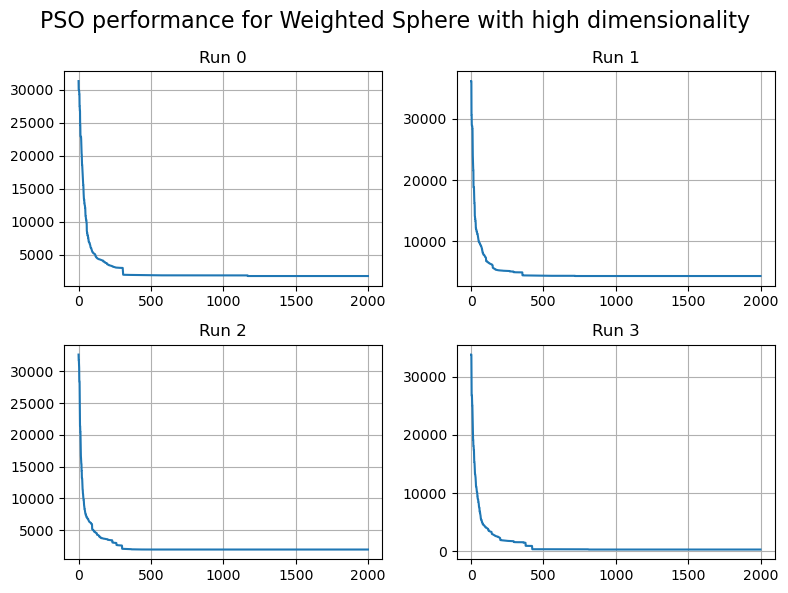

In [87]:
# Print best fitness and plot best fitness evolution graph
for i in range(4):
  print(f"Best fitness found for run {i}:", run_results[i][-1])

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle("PSO performance for Weighted Sphere with high dimensionality", fontsize=16)

for i in range(2):
  for j in range(2):
    axs[i, j].plot(run_results[i * 2 + j])
    axs[i, j].set_title(f"Run {i * 2 + j}")
    axs[i, j].grid()

plt.tight_layout()
plt.show()

## Experiment findings:
- We see that for a high dimensionality situation and a more complicated minimization function, most of the solution improvements happen during the first 500 iterations. This means that a max_iterations number higher than is not very useful.  
  
- Moreover, algorithm performance varies between the different runs and does not later on find improvements, which means that the final result may vary a lot between different runs. This means that in performance testing, an average value is preffered over a single experiment.  
  
- Lastly, while the algorithm does not seem to get too close to finding the global minimum (0) for high dimensionality applied to the Weighted Sphere function, these results still vastly outperform the previously implemented Genetic Algorithms in terms of execution time.  
  
- In conclusion, the Particle Swarm Optimization Algorithm is a simple and very efficient algorithm for function minimization which performs extremely well for simple functions (such as the Sphere function) and well for more complex functions (such as the Weighted Sphere function). In both cases the adaptive stratrgy version of the algorithm is preffered.